# Pareto Front
Parses results and plots a pareto front to visualize cost function.

## Environment setup

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns # for colors
from paretoset import paretoset

# specify plot settings such as figure size and font
plt.rcParams["figure.figsize"] = [7,4]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

## Import and parse results

In [2]:
# import results using geopandas and create subsets

results = []
results.append(gpd.read_file("../results/env_bruteforce_20231116_145503_0.1_5cages.geojson"))    # [0] all results

# divide all relevant columns by 1M to scale axis correctly
results[0]['wec_cost_NPV [$]'] = results[0]['wec_cost_NPV [$]'].div(1000000)
results[0]['vessel_travel_cost_NPV [$]'] = results[0]['vessel_travel_cost_NPV [$]'].div(1000000)
results[0]['obj_func'] = results[0]['obj_func'].div(1000000)

# separate data sets of interest
out = 600
results.append(results[0][results[0]['ok-conditions'] == '1'])                        # [1] results with data available
results.append(results[0][results[0]["wec_cost_NPV [$]"] < out])                      # [2] results with data available minus outliers
results.append(results[0][results[0]['valid_point'] == '1'])                          # [3] results that meet all constraints
results.append(results[3][results[3]["wec_cost_NPV [$]"] < out])                      # [4] results that meet all constraints minus outliers

In [3]:
# calculate optimal site and utopia point for each set

utopia = []
for res in results:
    utopia.append((res["wec_cost_NPV [$]"].min(), res["vessel_travel_cost_NPV [$]"].min()))
    
optimal = results[3][results[3]['obj_func']==results[3]['obj_func'].min()]

In [4]:
# calculate non-dominated pareto results for each set

pareto = []
for res in results:
    set = res[["wec_cost_NPV [$]", "vessel_travel_cost_NPV [$]"]]
    mask = paretoset(set, sense=["min", "min"])
    pareto.append(res[mask])

/usr/local/anaconda3/envs/imta/lib/python3.9/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/usr/local/anaconda3/envs/imta/lib/python3.9/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/usr/local/anaconda3/envs/imta/lib/python3.9/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/usr/local/anaconda3/envs/imta/lib/python3.9/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(s

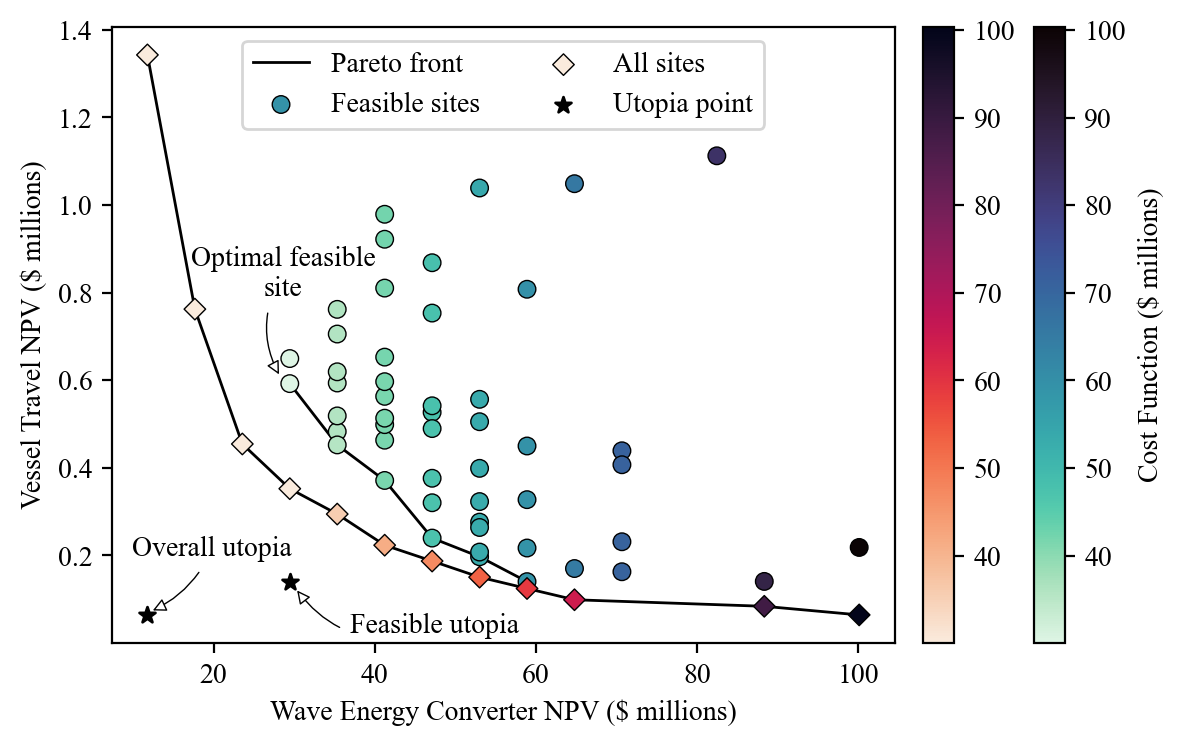

In [5]:
fig, ax = plt.subplots()

mako = sns.color_palette("mako_r", as_cmap=True)
rocket = sns.color_palette("rocket_r", as_cmap=True)
norm = mpl.colors.Normalize()

# pareto of feasible sites
ax.plot(pareto[4].sort_values("wec_cost_NPV [$]")["wec_cost_NPV [$]"],
        pareto[4].sort_values("wec_cost_NPV [$]")["vessel_travel_cost_NPV [$]"],
        color='black', linewidth=1, zorder=1)
# pareto of non-dominated sites
ax.plot(pareto[2].sort_values("wec_cost_NPV [$]")["wec_cost_NPV [$]"],
        pareto[2].sort_values("wec_cost_NPV [$]")["vessel_travel_cost_NPV [$]"],
        color='black', linewidth=1, label='Pareto front', zorder=1)

# scatter of feasible sites
ax.scatter(results[4]["wec_cost_NPV [$]"],
                 results[4]["vessel_travel_cost_NPV [$]"],
                 c=results[4]["obj_func"],
                 edgecolors='black', linewidth=0.5, marker="o", s=40,
                 cmap=mako, norm=norm, label='Feasible sites', zorder=2)
# scatter of non-dominated sites
ax.scatter(pareto[2]["wec_cost_NPV [$]"],
           pareto[2]["vessel_travel_cost_NPV [$]"],
                 c=pareto[2]["obj_func"],
                 edgecolors='black', linewidth=0.5, marker="D", s=30,
                 cmap=rocket, norm=norm, label='All sites', zorder=2)


# utopia feasible sites
ax.scatter(utopia[4][0], utopia[4][1], marker='*',
           edgecolors='black', linewidth=1, facecolor='black', zorder=1)
ax.annotate("Feasible utopia", xy=(utopia[4][0]+0.5, utopia[4][1]-0.01), xycoords='data',
            xytext=(utopia[4][0]+18, utopia[4][1]-0.1), textcoords='data',
            size=10, va="center", ha="center",
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=-0.4", fc="w", linewidth=0.5))

# utopia for non-dominated sites
ax.scatter(utopia[2][0], utopia[2][1], marker='*',
           edgecolors='black', linewidth=1, facecolor='black', label='Utopia point', zorder=1)
ax.annotate("Overall utopia", xy=(utopia[2][0]+0.04, utopia[2][1]+0.005), xycoords='data',
            xytext=(utopia[2][0]+8, utopia[2][1]+0.15), textcoords='data',
            size=10, va="center", ha="center",
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=-0.2", fc="w", linewidth=0.5))

ax.annotate("Optimal feasible\nsite", xy=(optimal["wec_cost_NPV [$]"]-1, optimal["vessel_travel_cost_NPV [$]"]+0.01), xycoords='data',
            xytext=(optimal["wec_cost_NPV [$]"]-0.85, optimal["vessel_travel_cost_NPV [$]"]+0.25), textcoords='data',
            size=10, va="center", ha="center",
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=0.3", fc="w", linewidth=0.5))

ax.set_xlabel("Wave Energy Converter NPV ($ millions)")
ax.set_ylabel("Vessel Travel NPV ($ millions)")
#ax.set_title("Cost Function Results")
ax.legend(loc='upper center', ncol=2)

cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mako), ax=ax, pad=-0.03, label="Cost Function ($ millions)")
cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=rocket), ax=ax, pad=0.03)

plt.savefig("pareto-all.pdf", dpi=300)
plt.show()

## Aimple plot of one of the results
Adjust *i* to change result plotted

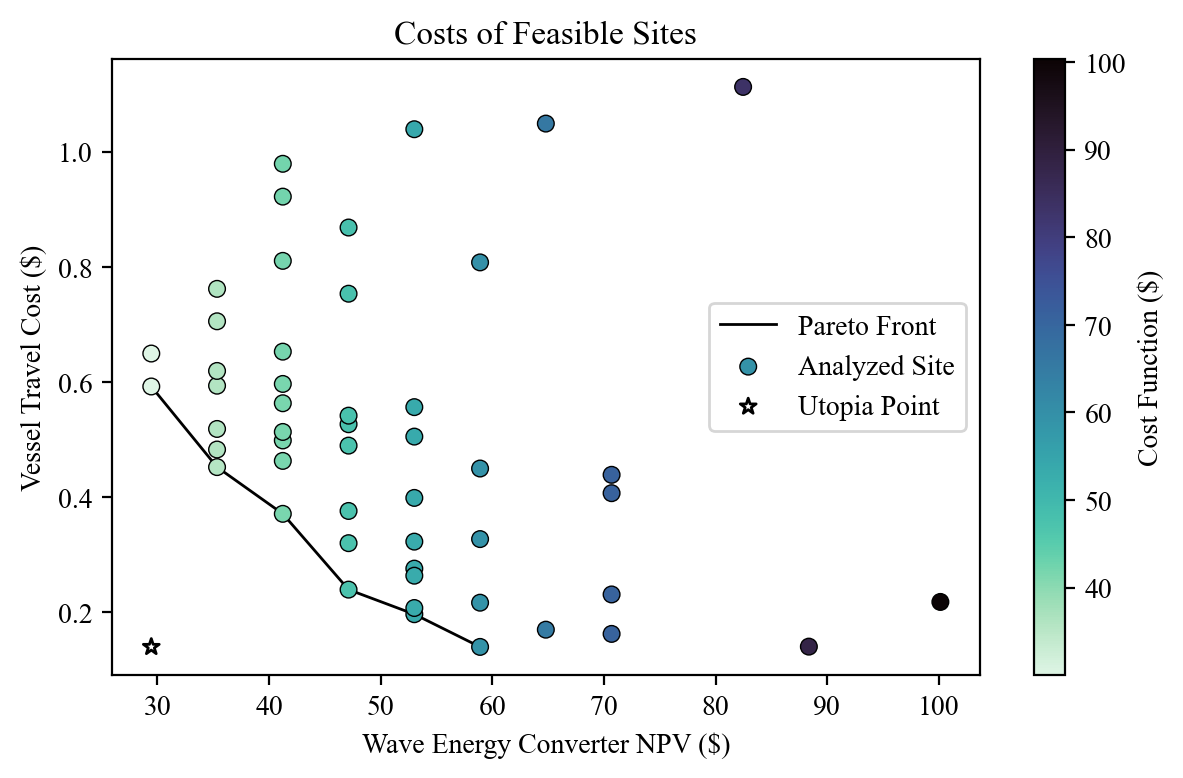

In [6]:
fig, ax = plt.subplots()

i = 4
cmap = sns.color_palette("mako_r", as_cmap=True)
norm = mpl.colors.Normalize()

ax.plot(pareto[i].sort_values("wec_cost_NPV [$]")["wec_cost_NPV [$]"],
        pareto[i].sort_values("wec_cost_NPV [$]")["vessel_travel_cost_NPV [$]"],
        color='black', linewidth=1, label='Pareto Front', zorder=1)
ax.scatter(results[i]["wec_cost_NPV [$]"],
                 results[i]["vessel_travel_cost_NPV [$]"],
                 c=results[i]["obj_func"],
                 edgecolors='black', linewidth=0.5,
                 cmap=cmap, norm=norm, label='Analyzed Site', zorder=2)
ax.scatter(utopia[i][0], utopia[i][1], marker='*',
           edgecolors='black', linewidth=1, facecolor='none',
           label='Utopia Point', zorder=3)

ax.set_xlabel("Wave Energy Converter NPV ($)")
ax.set_ylabel("Vessel Travel Cost ($)")
ax.set_title("Costs of Feasible Sites")
ax.legend()

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Cost Function ($)")

plt.show()

## Plot overall non-dominated results and all feasible results with annotations

## View feasible sites as table

In [7]:
results[3]

,pos_long,pos_lat,ok-conditions,ok-scope,ok-conflicts,obj_func,valid_point,vessel_travel_cost_NPV [$],wec_cost_NPV [$],fish_yield [kg],...,env_Umin_cons,env_Umax_cons,env_tempmin_cons,env_tempmax_cons,env_salinitymin_cons,env_salinitymax_cons,env_O2_min_cons,env_bathymetry_min_cons,env_bathymetry_max_cons,geometry
4439,-70.5,42.7,1,1,1,59.231637,1,0.327423,58.904214,675933.294374,...,0.044190,1.945810,8.030574,9.969426,1.004446,3.995554,5.146713,12.099998,42.900002,POINT (-70.50000 42.70000)
4539,-70.7,42.8,1,1,1,100.355492,1,0.218327,100.137164,675933.294374,...,0.015491,1.974509,7.824841,10.175159,0.679022,4.320978,5.153046,4.099998,50.900002,POINT (-70.70000 42.80000)
4540,-70.6,42.8,1,1,1,70.916374,1,0.231317,70.685057,675933.294374,...,0.017477,1.972523,7.962512,10.037488,0.868969,4.131031,5.157657,51.400002,3.599998,POINT (-70.60000 42.80000)
4641,-70.7,42.9,1,1,1,88.497078,1,0.140757,88.356321,675933.294374,...,0.035342,1.954658,7.759602,10.240398,0.844923,4.155077,5.170228,9.400002,45.599998,POINT (-70.70000 42.90000)
4642,-70.6,42.9,1,1,1,70.847902,1,0.162845,70.685057,675933.294374,...,0.042582,1.947418,7.820918,10.179082,1.011547,3.988453,5.174928,38.800003,16.199997,POINT (-70.60000 42.90000)
4644,-70.4,42.9,1,1,1,47.363090,1,0.239718,47.123371,675933.294374,...,0.054236,1.935764,8.015131,9.984869,1.315220,3.684780,5.180885,48.699997,6.300003,POINT (-70.40000 42.90000)
4847,-70.5,43.1,1,1,1,59.044473,1,0.140258,58.904214,675933.294374,...,0.045994,1.944006,7.631258,10.368742,1.418392,3.581608,5.211348,21.900002,33.099998,POINT (-70.50000 43.10000)
4848,-70.4,43.1,1,1,1,53.210796,1,0.197004,53.013793,675933.294374,...,0.075165,1.914835,7.803030,10.196970,1.478653,3.521347,5.215740,37.199997,17.800003,POINT (-70.40000 43.10000)
4851,-70.1,43.1,1,1,1,41.604210,1,0.371260,41.232950,675933.294374,...,0.071806,1.918194,8.064778,9.935222,1.681440,3.318560,5.231026,41.099998,13.900002,POINT (-70.10000 43.10000)
4949,-70.5,43.2,1,1,1,64.964816,1,0.170181,64.794636,675933.294374,...,0.013162,1.976838,7.509716,10.490284,1.491695,3.508305,5.226368,0.599998,54.400002,POINT (-70.50000 43.20000)
